In [1]:
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.join('./', 'nlmpy'))
from nlmpy import nlmpy
import numpy as np
import itertools

# Using Cons Bio Paper Landscape Sim Method: TODO

# Using NLMPY

In [2]:
NUM_ROWS = 50
NUM_COLS = 50

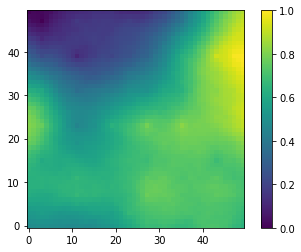

In [3]:
rastervals = nlmpy.mpd(NUM_ROWS, NUM_ROWS, 1.5)
# rastervals = (rastervals - np.mean(rastervals)) / np.std(rastervals) # should we standardize?
plt.imshow(rastervals, origin='lower')
plt.colorbar()

# Test Generated Raster with Simulation Code

## Simulate individual activity centers

In [4]:
def lambda_ipp_log_linear(x, beta0, beta1):
    """
    Rate function for an inhomogeneous poisson process, in which
    the intensity is a log-linear function of x.

    lambda = exp(beta0 + beta1*x)
    """
    return np.exp(beta0 + beta1*x)


def simulate_ipp(N, raster, n_real=1, seed=1111):
    """
    Simulates a spatial inhomogeneous Poisson process over 2D raster.
    Simulation is done using the Lewis and Schedler thinning algorithm.

    Args:
    N           - number of point events to simulate per realizition
    raster      - raster over which to simulate the IPP
    n_real      - number of realizations of the IPP to simulate
    seed        - random seed for the simulation

    Returns:
    points      - list of n_real lists; each sublist contains N tuples (x, y) specifying spatial 
                  points for one realization of the IPP.
    """
    np.random.seed(seed)

    n_pixels = np.prod(raster.shape)
    beta0 = np.log(float(N)/n_pixels)
    beta1 = -3
    min_rast_val = np.amin(raster)
    max_rast_val = np.amax(raster)
    lambda_max = max(lambda_ipp_log_linear(min_rast_val, beta0, beta1), lambda_ipp_log_linear(max_rast_val, beta0, beta1))
    
    points = [] # list points in each realization of the IPP
    for rno in range(n_real):
        counter = 0
        rpoints = [] # list of points for a single IPP realization
        while counter < N:
            x_coord = np.random.uniform(0, raster.shape[0], 1)[0]
            y_coord = np.random.uniform(0, raster.shape[1], 1)[0]
            z_val = raster[int(np.floor(x_coord)), int(np.floor(y_coord))]
            lambda_xy = lambda_ipp_log_linear(z_val, beta0, beta1)
            coin = np.random.uniform(0, 1, 1)[0]
            if coin < lambda_xy/lambda_max:
                counter += 1
                rpoints.append((x_coord, y_coord))
        points.append(rpoints)
    return points

In [5]:
ac_realizations = simulate_ipp(100, rastervals, n_real=1, seed=1234)


(0, 50)

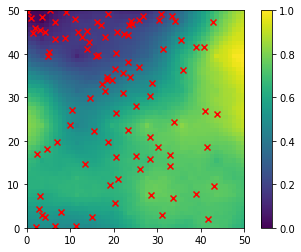

In [6]:
plt.imshow(rastervals, origin='lower', extent=(0, NUM_ROWS, 0, NUM_COLS))
plt.colorbar()
ac_x_coords = [t[0] for t in ac_realizations[0]]
ac_y_coords = [t[1] for t in ac_realizations[0]]
plt.scatter(ac_y_coords, ac_x_coords, c='r', marker='x')
plt.xlim([0, NUM_ROWS])
plt.ylim([0, NUM_COLS])

## Create grid layout for detectors

In [7]:
def create_grid_layout(n, m, raster, buffer=0.1):
    n_pix_h, n_pix_w = raster.shape
    grid_xmin = n_pix_h*buffer
    grid_xmax = n_pix_h*(1-buffer)
    grid_ymin = n_pix_w*buffer
    grid_ymax = n_pix_w*(1-buffer)

    grid_x = np.linspace(grid_xmin, grid_xmax, n)
    grid_y = np.linspace(grid_ymin, grid_ymax, m)
    grid_loc = list(itertools.product(grid_x, grid_y))

    return grid_loc

In [8]:
trap_loc = create_grid_layout(10, 10, rastervals)


Text(0, 0.5, 'Raster Cell Coords in Latitude Direction')

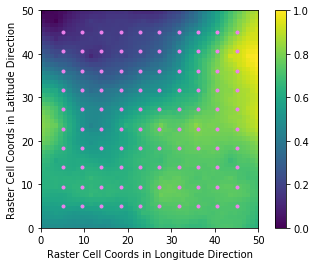

In [9]:
plt.imshow(rastervals, origin='lower', extent=(0, NUM_ROWS, 0, NUM_COLS))
plt.colorbar()
trap_x_coords = [t[0] for t in trap_loc]
trap_y_coords = [t[1] for t in trap_loc]
plt.scatter(trap_y_coords, trap_x_coords, c='violet', marker='.')
plt.xlim([0, NUM_ROWS])
plt.ylim([0, NUM_COLS])
plt.xlabel('Raster Cell Coords in Longitude Direction')
plt.ylabel('Raster Cell Coords in Latitude Direction')

(0, 50)

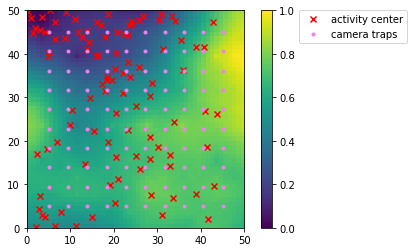

In [10]:
# Visualize together
plt.imshow(rastervals, origin='lower', extent=(0, NUM_ROWS, 0, NUM_COLS))
plt.colorbar()
trap_x_coords = [t[0] for t in trap_loc]
trap_y_coords = [t[1] for t in trap_loc]
plt.scatter(ac_y_coords, ac_x_coords, c='r', marker='x', label='activity center')
plt.scatter(trap_y_coords, trap_x_coords, c='violet', marker='.', label='camera traps')
plt.legend(loc=(1.25,0.85))
plt.xlim([0, NUM_ROWS])
plt.ylim([0, NUM_COLS])

## Load trap locations from file

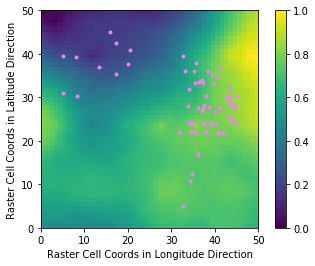

In [11]:
import pandas as pd
data = pd.read_csv('../sebangau lat long 1 loc.csv')
max_latitude = data['Latitude'].max()
min_latitude = data['Latitude'].min()
max_longitude = data['Longitude'].max()
min_longitude = data['Longitude'].min()
# print(max_latitude)
# print(min_latitude)
# print(max_longitude)
# print(min_longitude)
plt.imshow(rastervals, origin='lower', extent=(0, NUM_ROWS, 0, NUM_COLS))
plt.colorbar()
trap_x_coords = []
for lon in data['Longitude']:
    rasterv = ((lon-min_longitude)/(max_longitude-min_longitude)) * 40 + 5
    trap_x_coords.append(rasterv)
trap_y_coords = []
for lat in data['Latitude']:
    rasterv = ((lat-min_latitude)/(max_latitude-min_latitude)) * 40 + 5
    trap_y_coords.append(rasterv)
plt.scatter(trap_y_coords, trap_x_coords, c='violet', marker='.')
plt.xlim([0, NUM_ROWS])
plt.ylim([0, NUM_COLS])
plt.xlabel('Raster Cell Coords in Longitude Direction')
plt.ylabel('Raster Cell Coords in Latitude Direction')
trap_cords = []
for val in range(len(trap_x_coords)):
    trap_cords.append((trap_x_coords[val],trap_y_coords[val]))

In [23]:
import rasterio
from utils import find_lcp_to_pts
def simulate_capture_histories(ac, tl, K, lcp_dist, alpha0, alpha1, n_real=50, seed=1111):
    """
    Simulates a capture history for a simulated spatial capture-recapture study.
    Assumes multiple individuals can be detected at each detector in a given sampling
    occasion--but multiple detections of the same individual at the same trap in a
    single sampling occasion are indistinguishable.
    Args:
    ac          - list of tuples (x,y) storing activity center locations
    tl          - list of tuples (x,y) storing trap locations
    K           - number of sampling occasions
    lcp_dist    - least cost paths between each trap and every raster pixel
    alpha0      - capture probability parameter
    alpha1      - home range parameter
    n_real      - number of realizations of the capture history to simulate
    seed        - random seed for the simulation
    Returns:
    detections  - matrix of the number of times each individual was detected at
                  each detector
    """
    n_individuals = len(ac)
    n_traps = len(tl)
    detections = []
    for rno in range(n_real):
        rdetections = np.ndarray((n_individuals, n_traps))
        for ni in range(len(ac)):
            s = ac[ni]
            sx = int(np.floor(s[0]))
            sy = int(np.floor(s[0]))
            for nt in range(len(tl)):
                dist = lcp_dist[nt, sx, sy]
                prob_cap = (1/(1+np.exp(alpha0)))*np.exp(-alpha1*dist*dist)
                n_det = np.random.binomial(K, prob_cap)
                rdetections[ni, nt] = n_det
        rdetections = rdetections[~np.all(rdetections==0, axis=1)]
        detections.append(rdetections)
    return(detections)

In [28]:
lcp_distances = find_lcp_to_pts(rastervals, 1.75, trap_cords, raster_cell_size=1)
capture_histories = simulate_capture_histories(ac_realizations[0],trap_cords,10,lcp_distances,0.9,1.75)
print(capture_histories)

[array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape=(0, 67), dtype=float64), array([], shape